<a href="https://colab.research.google.com/github/HSKrab/data-course-sample/blob/main/sample_content_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Code

## 基礎建設

In [1]:
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta

In [2]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [3]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2022-01-01 16:11:25--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv.24’

All_Beauty.csv.24   100%[===================>]  14.78M  23.5MB/s    in 0.6s    

2022-01-01 16:11:25 (23.5 MB/s) - ‘All_Beauty.csv.24’ saved [15499476/15499476]

--2022-01-01 16:11:26--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz.24’

meta_All_Beauty.jso 100%[===================>]   9.85M  18.7MB/s    in 0.5s

In [4]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [5]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [6]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [7]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')
ratings.sort_values(by=['DATE'], inplace=True, ascending=True)
ratings

,asin,reviewerID,overall,unixReviewTime,DATE
256078,3317005939,AL2PQBKHP7LM4,5.0,947462400,2000-01-10
261647,0061073717,ATKPYXA8XFKGJ,5.0,957571200,2000-05-06
261646,0061073717,A2XMFX1BR0IJFJ,5.0,959990400,2000-06-03
256161,B000050B62,A1U7T7UCCV3SBN,5.0,972777600,2000-10-29
5299,B000050FDP,A3RVIXD86WUT1E,5.0,973987200,2000-11-12
...,...,...,...,...,...
370903,B01HC6G4D6,A1RAXJN2Q4V20X,4.0,1538265600,2018-09-30
369982,B01GZWUSYY,A1M8YMS915ZK0B,1.0,1538265600,2018-09-30
368687,B01GIYE88G,A3RTH0S9XVBPVK,5.0,1538352000,2018-10-01
368798,B01GJQXRLC,A3ORA680FWE8SW,5.0,1538352000,2018-10-01


首先看了metadata的資料後發現有許多column的資訊非常不足，為確保每個column的存在都能為模型帶來效益，希望消除資訊過少的column。</br>
統計每個 column 共有幾種數據。

In [8]:
for col in metadata:
  print(str(metadata[col].astype(str).nunique())+' data in '+col+' col.')

1 data in category col.
11 data in tech1 col.
13751 data in description col.
1 data in fit col.
32300 data in title col.
6482 data in also_buy col.
1 data in tech2 col.
7863 data in brand col.
230 data in feature col.
31949 data in rank col.
7894 data in also_view col.
32329 data in details col.
1 data in main_cat col.
1301 data in similar_item col.
20 data in date col.
3530 data in price col.
32488 data in asin col.
15737 data in imageURL col.
15737 data in imageURLHighRes col.


發現 metadata 中 index 425 至 828 之間，共404筆資料是跟之前的 index 重複的，將完全重複的 row 去掉。</br>
P.S. 欄位中有包含 list 的 type 所以剛開始只寫 metadata.drop_duplicates() 有噴錯。

In [9]:
print(len(metadata['asin']),len(set(metadata['asin'])))		
s,rep=set(),list()
for i,asin in enumerate(metadata['asin']):
  if asin not in s:
    s.add(asin)
  else:
    rep.append(i)
print(rep)
metadata=metadata.loc[metadata.astype(str).drop_duplicates().index]
metadata

32892 32488
[425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 62

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32887,[],,[],,"Barielle Pro Textured Grip Cuticle Nipper, Purple",[],,,[],"2,145,325 in Beauty & Personal Care (",[],{'ASIN: ': 'B01HIWLLUK'},All Beauty,,,$9.95,B01HIWLLUK,[],[]
32888,[],,[],,(Buy 3 Get 1 Free) Salon Perfect Eye Makeup Co...,[],,Salon Perfect,[],"1,639,713 in Beauty & Personal Care (",[],"{'ASIN: ': 'B01HJ1K3YK', 'UPC:': '671635851871'}",All Beauty,,,,B01HJ1K3YK,[],[]
32889,[],,[],,NOW D-Mannose 500 mg - 120 Veg Capsules (Pack ...,"[B01KON9B4S, B079X3YFXS, B00M79OYS6, B000JN4CR...",,,[],"207,410 in Beauty & Personal Care (","[B01KON9B4S, B000JN4CR0, B071ZHMRHS, B01HJ84TN...","{'Shipping Weight:': '1 pounds (', 'ASIN: ': '...",All Beauty,,,$55.63,B01HJ84SGM,[],[]
32890,[],,[Brand new and high quality<br> Enables fast v...,,12 White Feather Shuttlecocks Birdies Badminto...,[],,GBSTORE,[],"965,673 in Beauty & Personal Care (",[],"{'Shipping Weight:': '4.8 ounces (', 'ASIN: ':...",All Beauty,,,$12.99,B01HJASD20,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


觀察metadata的資料結構後，將資訊含量過少的 column 去掉。</br>
另外如main_cat全部欄位的資訊都是All Beauty，判斷無助於分析，因此也去掉。

In [10]:
a=[]
for i,asin in enumerate(metadata['main_cat']):
  if asin !='All Beauty':
    a.append(i)

if not a: print('Info of main_cat are all the same.')

metadata=metadata[['description','title','also_buy','brand','rank','also_view','details','price','asin']]
metadata

Info of main_cat are all the same.


,description,title,also_buy,brand,rank,also_view,details,price,asin
0,[Loud 'N Clear Personal Sound Amplifier allows...,Loud 'N Clear&trade; Personal Sound Amplifier,[],idea village,"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},,6546546450
1,[No7 Lift & Luminate Triple Action Serum 50ml ...,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",$44.99,7178680776
2,[No7 Stay Perfect Foundation now stays perfect...,No7 Stay Perfect Foundation Cool Vanilla by No7,[],No7,"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",$28.76,7250468162
3,[],Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",,7367905066
4,[Lacto Calamine Skin Balance Daily Nourishing ...,Lacto Calamine Skin Balance Oil control 120 ml...,[],Pirmal Healthcare,"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",$12.15,7414204790
...,...,...,...,...,...,...,...,...,...
32887,[],"Barielle Pro Textured Grip Cuticle Nipper, Purple",[],,"2,145,325 in Beauty & Personal Care (",[],{'ASIN: ': 'B01HIWLLUK'},$9.95,B01HIWLLUK
32888,[],(Buy 3 Get 1 Free) Salon Perfect Eye Makeup Co...,[],Salon Perfect,"1,639,713 in Beauty & Personal Care (",[],"{'ASIN: ': 'B01HJ1K3YK', 'UPC:': '671635851871'}",,B01HJ1K3YK
32889,[],NOW D-Mannose 500 mg - 120 Veg Capsules (Pack ...,"[B01KON9B4S, B079X3YFXS, B00M79OYS6, B000JN4CR...",,"207,410 in Beauty & Personal Care (","[B01KON9B4S, B000JN4CR0, B071ZHMRHS, B01HJ84TN...","{'Shipping Weight:': '1 pounds (', 'ASIN: ': '...",$55.63,B01HJ84SGM
32890,[Brand new and high quality<br> Enables fast v...,12 White Feather Shuttlecocks Birdies Badminto...,[],GBSTORE,"965,673 in Beauty & Personal Care (",[],"{'Shipping Weight:': '4.8 ounces (', 'ASIN: ':...",$12.99,B01HJASD20


統一處理 metadata 各個 column 的資訊：</br>
description: str</br>
title: str</br>
also_buy/also_view: list</br>
brand: str</br>
rank: int or ''</br>
details: dict</br>
price: float or ''</br>

追加 ranktype: str (原先 rank 欄位後面的內容)

In [11]:
metadata['description'] = metadata['description'].apply(lambda x:x[0] if x else '')
metadata['title'] = metadata['title'].apply(lambda x:x if x else '')
metadata['also_buy'] = metadata['also_buy'].apply(lambda x:x if type(x) is list else [])
metadata['brand'] = metadata['brand'].apply(lambda x:x if x else '')
#metadata['rank'] = pd.to_numeric(metadata['rank'].str.split(expand = True)[0].str.replace(',', ''))
metadata['ranktype'] = metadata['rank'].apply(lambda x:x.split(' in ')[1].replace(' (', '') if type(x) is str else '')
metadata['rank'] = metadata['rank'].apply(lambda x:int(x.split(' ')[0].replace(',', '')) if type(x) is str else '')
metadata['also_view'] = metadata['also_view'].apply(lambda x:x if type(x) is list else [])
metadata['details'] = metadata['details'].apply(lambda x:x if type(x) is dict else {})
metadata['price'] = metadata['price'].apply(lambda x:float(x.replace('$','').replace(',','')) if x and len(x)<10 else '')

#Method 1: Combine title, brand, ranktype.
#metadata['trainstr']=metadata['title'].str.cat(metadata[['brand', 'ranktype']], sep=' ')
#metadata['trainstr']=metadata['trainstr'].apply(lambda x:''.join([c for c in x if c.isalnum() or c==' ' ]))
#Result: No sufficient RAM

#Method 2: Combine title, brand, ranktype, with brand replaced with XXXX and ranktype with XXXX
#XXXX means four randomized characters which x.isalnum() is True.
#metadata['trainstr']=metadata['title'].str.cat(metadata[['brand', 'ranktype']], sep=' ')
#metadata['trainstr']=metadata['trainstr'].apply(lambda x:''.join([c for c in x if c.isalnum() or c==' ' ]))
#Result: No sufficient RAM

metadata

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,description,title,also_buy,brand,rank,also_view,details,price,asin,ranktype
0,Loud 'N Clear Personal Sound Amplifier allows ...,Loud 'N Clear&trade; Personal Sound Amplifier,[],idea village,2938573,[],{'ASIN: ': '6546546450'},,6546546450,Beauty & Personal Care
1,No7 Lift & Luminate Triple Action Serum 50ml b...,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,872854,[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",44.99,7178680776,Beauty & Personal Care
2,No7 Stay Perfect Foundation now stays perfect ...,No7 Stay Perfect Foundation Cool Vanilla by No7,[],No7,956696,"[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",28.76,7250468162,Beauty & Personal Care
3,,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,1870258,[],"{' Item Weight: ': '1.76 ounces', 'Sh...",,7367905066,Beauty & Personal Care
4,Lacto Calamine Skin Balance Daily Nourishing L...,Lacto Calamine Skin Balance Oil control 120 ml...,[],Pirmal Healthcare,67701,"[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",12.15,7414204790,Beauty & Personal Care
...,...,...,...,...,...,...,...,...,...,...
32887,,"Barielle Pro Textured Grip Cuticle Nipper, Purple",[],,2145325,[],{'ASIN: ': 'B01HIWLLUK'},9.95,B01HIWLLUK,Beauty & Personal Care
32888,,(Buy 3 Get 1 Free) Salon Perfect Eye Makeup Co...,[],Salon Perfect,1639713,[],"{'ASIN: ': 'B01HJ1K3YK', 'UPC:': '671635851871'}",,B01HJ1K3YK,Beauty & Personal Care
32889,,NOW D-Mannose 500 mg - 120 Veg Capsules (Pack ...,"[B01KON9B4S, B079X3YFXS, B00M79OYS6, B000JN4CR...",,207410,"[B01KON9B4S, B000JN4CR0, B071ZHMRHS, B01HJ84TN...","{'Shipping Weight:': '1 pounds (', 'ASIN: ': '...",55.63,B01HJ84SGM,Beauty & Personal Care
32890,Brand new and high quality<br> Enables fast vo...,12 White Feather Shuttlecocks Birdies Badminto...,[],GBSTORE,965673,[],"{'Shipping Weight:': '4.8 ounces (', 'ASIN: ':...",12.99,B01HJASD20,Beauty & Personal Care


## EDA (Exploratory Data Analysis) 


濾掉不必要的 column 後，title column 有 32300 種值，然而 asin column 卻有 32488 種值。</br>
證明了不同商品卻有相同 title 的狀況。

In [12]:
for col in metadata:
  print(str(metadata[col].astype(str).nunique())+' data in '+col+' col.')
metadata.shape

13274 data in description col.
32300 data in title col.
6482 data in also_buy col.
7863 data in brand col.
31878 data in rank col.
7894 data in also_view col.
32329 data in details col.
3526 data in price col.
32488 data in asin col.
14 data in ranktype col.


(32488, 10)

In [13]:
s=set()
c=0
for i,t in enumerate(metadata['title']):
  if t not in s:
    s.add(t)
  else:
    c+=1
    print(i,t)
  if t=='':
    print('No title:')
    print(i)
print(len(metadata['title']))
print(c)

610 Pre de Provence Artisanal French Soap Bar Enriched with Shea Butter, Quad-Milled For A Smooth &amp; Rich Lather (250 grams) - Linden
636 Pre de Provence Artisanal French Soap Bar Enriched with Shea Butter, Quad-Milled For A Smooth &amp;...
896 Pre de Provence Artisanal French Soap Bar Enriched with Shea Butter, Quad-Milled For A Smooth &amp;...
969 Ralph by Ralph Lauren for Women, You've Got Gel Shower Gel, 6.7 Ounce
970 Waterpik Ultra Water Flosser
1052 Gotu Kola 450mg Now Foods 100 Caps
1483 Oral-B Humming Bird Flosser Refills (Pack of 15)
1837 ZENO 60-Count Replacement Tip
1848 Helen of Troy 1579 Tangle Free Hot Air Brush, White, 3/4 Inch Barrel
2039 Nullo Internal Deodorant (60 Caplets)
2757 Oral-B Glide Pro-Health Original Floss Twin Pack 100 M
3602 Philips Sonicare HX6042/60 Sonicare for Kids Brush Heads, Ages 7-10, 2-Pack
4077 Kerastase Nutritive Bain Satin Nutrition 1 Shampoo 8.5 oz
4160 Bed Head Ego Boost Split End Mender By Tigi, 8 Ounce
4457 Avalon Organics Baby Lotion, 

In [14]:
metadata['ranktype'].value_counts()

Beauty & Personal Care        31541
Beauty &amp; Personal Care      474
                                402
Grocery & Gourmet Food           35
Health & Household               19
Toys & Games                      3
Sports & Outdoors                 3
Health &amp; Household            2
Grocery &amp; Gourmet Food        2
Clothing, Shoes & Jewelry         2
Baby                              2
Tools & Home Improvement          1
Automotive                        1
Home & Kitchen                    1
Name: ranktype, dtype: int64

In [15]:
metadata['brand'].value_counts()

                                    15570
VAGA                                  252
L'Oreal Paris                         110
Betty Dain                             82
Unknown                                79
                                    ...  
sunkiller                               1
Leritone                                1
Streetwise                              1
Goya                                    1
Nothing But Quality, Ching Ching        1
Name: brand, Length: 7863, dtype: int64

原始 metadata 資料中，價格分布狀況。

The max price of all time: 2149.0


Text(0.5, 0, 'US dollars')

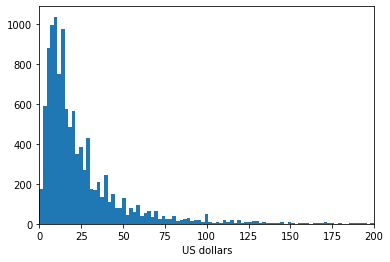

In [16]:
price=metadata[metadata['price'] != '']
print('The max price of all time: '+str(max(price['price'])))
plt.hist(metadata[metadata['price'] != '']['price'],bins=1000)
plt.xlim(0,200)
plt.xlabel('US dollars')

改寫自 Ana 同學的第一週作業 EDA 的內容，在此統計「原始資料」中購買者和商品的重複率，發現：<br>
<ul>
<li>9成以上的商品被重複購入過。(32,586/371,345 < 10%)
<li>8.7成左右的評論來自新用戶。(324,038/371,345 ~ 87%)
<li>在評論數據庫裡，有商品不在原始的商品數據庫。(32,586 > 32,488)</li>

In [17]:
print(f'Total orders: {ratings.shape[0]:,}')
print(f'Total products: {metadata.asin.nunique():,}')
print(f'Unrepeated products: {ratings.asin.nunique():,}')
print(f'Unrepeated users: {ratings.reviewerID.nunique():,}')

Total orders: 371,345
Total products: 32,488
Unrepeated products: 32,586
Unrepeated users: 324,038


統計每個月的評價數中，總評價數和新用戶的評價數

In [18]:
date,reviewer,new_reviewer=[],[],[]

month=datetime.date(2000,1,1)
count,s=0,set()
start,end=0,0
while month<=datetime.date(2018,9,1):
  while ratings['DATE'].iloc[end]<month+relativedelta(months=1):
    if ratings['reviewerID'].iloc[end] not in s:
      count+=1
    end+=1
  s=set(ratings['reviewerID'].iloc[:end])
  reviewer.append(len(ratings['reviewerID'].iloc[start:end]))
  new_reviewer.append(count)
  #new_reviewer.append(len(set(ratings['reviewerID'].iloc[start:end])))
  date.append(month)
  start=end
  count=0
  month+=relativedelta(months=1)

對時間做圖後發現：
<br>
<ul>
<li>2016, 17年訂單數到達高峰後逐月下降。
<li>每月訂單中，新進用戶的訂單數量佔比極高。</li>
</ul>

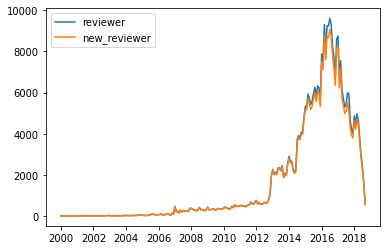

In [19]:
plt.plot(date,reviewer,label='reviewer')
plt.plot(date,new_reviewer,label='new_reviewer')
plt.legend()

重複買家購入相同物品/重複買家 的 評價筆數 (共 19,218/83,561 筆)

In [20]:
ratings.duplicated(subset=['reviewerID'],keep=False).value_counts()

False    287784
True      83561
dtype: int64

In [21]:
ratings.duplicated(subset=['asin','reviewerID'],keep=False).value_counts()

False    352127
True      19218
dtype: int64

評論分數分佈統計

In [22]:
ratings['overall'].value_counts()

5.0    229549
4.0     52687
1.0     39261
3.0     29555
2.0     20293
Name: overall, dtype: int64

## 資料切分

In [23]:
def cut(predict,ratings=ratings):
  """
  let predict be the first day of any month.
  """
  train = ratings[
    (ratings['DATE'] < str(predict))
  ]
  test = ratings[
    (ratings['DATE'] >= str(predict)) & 
    (ratings['DATE'] < str(predict+relativedelta(months=1)))
  ]
  return train,test

In [24]:
"""
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
"""
ratings_trainings,ratings_testings=cut(predict=datetime.date(2018,9,1))
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

## 產生推薦

EDA 的過程發現「不同商品卻有相同 title 的狀況」。但分析後又發現重複買家購入相同物品/重複買家 的 評價筆數 19,218/83,561 = 23%，因此判斷無需完全排除推薦已經購入過的商品。</br>
另外，此處發現一個原始 code 的 bug，原先跑出來的結果總是掛蛋，但後來發現 matrix 的 index 和 df 的 index 不一致，因此輸出會對不上輸入，在此加入</br>
```python 
df=df.reset_index()
```
後，終於順利產出第一個非零的評估分數。

在此以不同計算 similarity 的方法來進行評估。</br>
https://dataaspirant.com/five-most-popular-similarity-measures-implementation-in-python/</br>
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.pairwise


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 計算商品用標題所表示的 tfidf 矩陣
tr='title'
df = metadata.drop_duplicates(tr)
df = df.reset_index()
tf = TfidfVectorizer(analyzer='word')
tfidf_matrix = tf.fit_transform(df[tr])


# 計算商品間的相似程度: cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(tfidf_matrix)
mapping = pd.Series(df.index,index = df[tr])


# 計算商品間的相似程度: manhattan_distances
#from sklearn.metrics.pairwise import manhattan_distances
#similarity_matrix = manhattan_distances(tfidf_matrix)
#mapping = pd.Series(df.index,index = df[tr])

# 計算商品間的相似程度: euclidean_distances
#from sklearn.metrics.pairwise import euclidean_distances
#similarity_matrix = euclidean_distances(tfidf_matrix)
#mapping = pd.Series(df.index,index = df[tr])


In [26]:
# 每個商品回傳 k 個最相近的商品
def recommend_item(item_input, k=2):
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(similarity_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        #item_indices = [i[0] for i in similarity_score]
        #return (df['asin'].iloc[item_indices].tolist())
        return similarity_score
    except:
        return []

# 利用使用者購買過的商品產生推薦
def recommend_items(items, k):
    res = []
    for d in items:
        res.extend(recommend_item(d,k))
    res=sorted(res, key=lambda x: x[1], reverse=True)
    return res

def sum_of_rank(res,k):
    new_r={}
    for r in res:
      if r[0] in new_r:
        if r[1]>new_r[r[0]]:
          new_r[r[0]]=r[1]
      else:
        new_r.update({r[0]:r[1]})

    new=sorted([(key,val) for key,val in new_r.items()],key=lambda x:x[1], reverse=True)
    return df['asin'].iloc[[n[0] for n in new][:k]].tolist()

In [27]:
recommend_item("Loud 'N Clear&trade; Personal Sound Amplifier",10)

[(0, 1.0),
 (3830, 0.28563333171910793),
 (2786, 0.28226222792563316),
 (6620, 0.26944712134056226),
 (20098, 0.24601713248072804),
 (17592, 0.24478486400911711),
 (31279, 0.23761748780134645),
 (9018, 0.23175230897167504),
 (5722, 0.23023095709297986),
 (8233, 0.22619185012036327)]

由於跑 recommend_item 頗耗時，這邊僅提供兩段隨機指定的範圍結果做參考。</br>
發現大部分每一個商品的第一推薦都是自己。但偶有自己是在第二推薦順位的情況。</br>


In [28]:

#此範圍內，自己都是第一推薦順位。
observe = [df['asin'].loc[i] == df['asin'].loc[recommend_item(df['title'].loc[i],5)[0][0]] for i in range(16277,16605) if i in df['title'].index]
print(len([o for o in observe if not o]))
print(all(observe))

#然而此範圍內找到3個例子是落在第二順位。
for i in range(20510,20800):
  if i in df['title'].index:
    r = df['asin'].iloc[[r[0] for r in recommend_item(df['title'].loc[i],k=5)]].tolist()
    if df['asin'].loc[i] != r[0]:
      print(i,df['asin'].loc[i],r)



0
True
20554 B00Y2I3TYA ['B00Y2I3EOU', 'B00Y2I3TYA', 'B00U0Z2XMI', 'B00J8LSAJK', 'B0037M6VZG']
20707 B00YGREQWG ['B00YGRER6G', 'B00YGREQWG', 'B00E523SQM', 'B008EKXN52', 'B00KODA76A']
20713 B00YHRSW98 ['B00QX9PXAO', 'B00YHRSW98', 'B00UIVDYCM', 'B014LH8IMO', 'B01BW5TILI']


探討自己的順位不是第一位的原因。</br>
推斷兩個 title 內容幾乎相同、score 一樣的情況下，排序會照原先的 index。

In [29]:
rec=recommend_item(df['title'].loc[20554],10)
score = [s[1]for s in rec]
index = [r[0] for r in rec]
title=df['title'].iloc[[r[0] for r in rec]].tolist()
pd.DataFrame([(score[i],index[i],title[i]) for i in range(10)],columns=['score','index','title'])

,score,index,title
0,1.000000,20553,Lava Pumice-powered Heavy-duty Hand Bar Soap 5...
1,1.000000,20554,Lava Pumice-powered Heavy-duty Hand Bar Soap 5...
2,0.770047,18996,"Lava Heavy-Duty Hand Soap, Bar 5.75 oz (pack o..."
3,0.396249,12578,Heavy Duty Cellulite Cream 6.8 Oz.
4,0.367758,3944,Develop 10 Pumice Lava Rock
5,0.343860,15018,"Lava - Hand Soap, Unscented Bar, 4oz - 48/Carton"
6,0.338481,1207,Foot Stool Heavy-Duty
7,0.326563,4975,Red Heavy Duty Tattoo Clip Cord
8,0.326268,20078,Really Works Hand Cleaner Heavy Duty SMOOTH (N...
9,0.258296,14114,Probiotic Hand Soap Bar - 3 Pack


In [30]:
def recommender(training_data, users=[], k=30):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
    '''
    content-based
    '''
    ratings_trainings = training_data
    recommendations = {user: sum_of_rank(recommend_items(metadata[metadata['asin'].isin(ratings_trainings[ratings_trainings['reviewerID'] == user]['asin'].tolist())]['title'].tolist(), k),k) for user in users}

    return recommendations

ratings_by_user = recommender(ratings_trainings, users)

In [31]:
#r_by_u={}
#for user in ratings_by_user:
sta=pd.DataFrame({'len':[len(re) for re in list(ratings_by_user.values())]}) 
sta.value_counts()

len
0      546
30      38
dtype: int64

## 結果評估

向量計算量龐大，無法同時秀出計算不同 similarity 的結果，因此在此記錄下曾經計算過的數據。</br>
推薦數 k = 10，測試資料為2018.7.1起 / 9.1起 至 9.30，測試過的方法為以下三種:</br>
<ul>
<li>cosine_similarity: 0.0028 / 0.0051 (排序時reverse = True)
<li>euclidean_distances: 0.0024 / 0.0051 (排序時reverse = False)
<li>manhattan_distances: 0.0017 / 0.0034 (排序時reverse = False)</li>

推薦數 k = 30，測試資料為2018.7.1起 / 9.1起 至 9.30，測試過的方法為以下三種:</br>
<ul>
<li>cosine_similarity: 0.0032 / 0.0051 (排序時reverse = True)
<li>euclidean_distances: 0.0032 / 0.0051 (排序時reverse = False)
<li>manhattan_distances: 0.0024 / 0.0051 (排序時reverse = False)</li>

結論：整體差異並不大，至少沒有任何算法出現壓倒性的優勢，考慮並沒有太多時間研究其他相關度，因此決定取 cosine_similarity 作為本次作業的主要算法。

In [63]:
def evaluate(ratings_testings,ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings,ratings_testings_by_user, ratings_by_user)

0.005084745762711864

##結合上週的 rule-based

Top-k 推薦邏輯為
<li>沒有歷史資料的新進用戶：推薦產品為過去 n 個月最高 round(k/2) 個人氣產品，以及與此 k//2 個產品相關性最高的其他 5 個產品。
<li>既有客戶：推薦產品為購入過產品中相關性最高的前 k//2 名（但將購入過的產品排除），以及過去 n 個月最高 round(k/2) 個人氣產品。

程式碼修正

In [35]:
# 每個商品回傳 k 個最相近的商品
def recommend_item1(item_input, k=2):
    try:
        i=df.index[df['title']==item_input].tolist()[0]
        item_index = mapping[item_input]
        similarity_score = list(enumerate(similarity_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = list(filter(lambda x:x[0]!=i, similarity_score))
        similarity_score = similarity_score[:k]
        return similarity_score
    except:
        return []

# 利用使用者購買過的商品產生推薦
def recommend_items1(items, k):
    res = []
    for d in items:
        res.extend(recommend_item1(d,k))
    res=sorted(res, key=lambda x: x[1], reverse=True)
    return res

def sum_of_rank1(res,k):
    new_r={}
    for r in res:
      if r[0] in new_r:
        if r[1]>new_r[r[0]]:
          new_r[r[0]]=r[1]
      else:
        new_r.update({r[0]:r[1]})

    new=sorted([(key,val) for key,val in new_r.items()],key=lambda x:x[1], reverse=True)
    return df['asin'].iloc[[n[0] for n in new][:k]].tolist()

In [36]:
old = ratings_testings['reviewerID'][ratings_testings['reviewerID'].isin(set(ratings_trainings['reviewerID']))].tolist()
new = ratings_testings['reviewerID'][ratings_testings['reviewerID'].isin(set(ratings_trainings['reviewerID'])) == False].tolist()

In [58]:
def combine(training_data, users=[], k=10,sp_old=5,sp_new=5):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    ratings_trainings = training_data[
    (training_data['DATE'] >= '2018-08-01') & 
    (training_data['DATE'] < '2018-09-01')]
    
    #過去 1 個月最高 round(k/2) 個人氣產品
    popular = list(ratings_trainings['asin'].value_counts().keys())[:k]
    pop_t = metadata['title'][metadata['asin'].isin(popular)].tolist()
    pop_rec = sum_of_rank1(recommend_items1(pop_t, k),k)
    
    #既有用戶
    recom = {user:sum_of_rank1(recommend_items1(metadata[metadata['asin'].isin(
                  ratings_trainings[ratings_trainings['reviewerID'] == user]['asin'].tolist())][
                  'title'].tolist(),10),10)[:k-sp_old] + popular[:sp_old] for user in old}

    #新進用戶
    recom.update({user: popular[:sp_new]+pop_rec[:k-sp_new] for user in new})
    
    return recom
    

In [61]:
comb = combine(ratings_trainings, users,k=10,sp_old=10,sp_new=10)
evaluate(ratings_testings,ratings_testings_by_user, comb)

0.15254237288135594

Text(0.5, 1.0, 'Prediction')

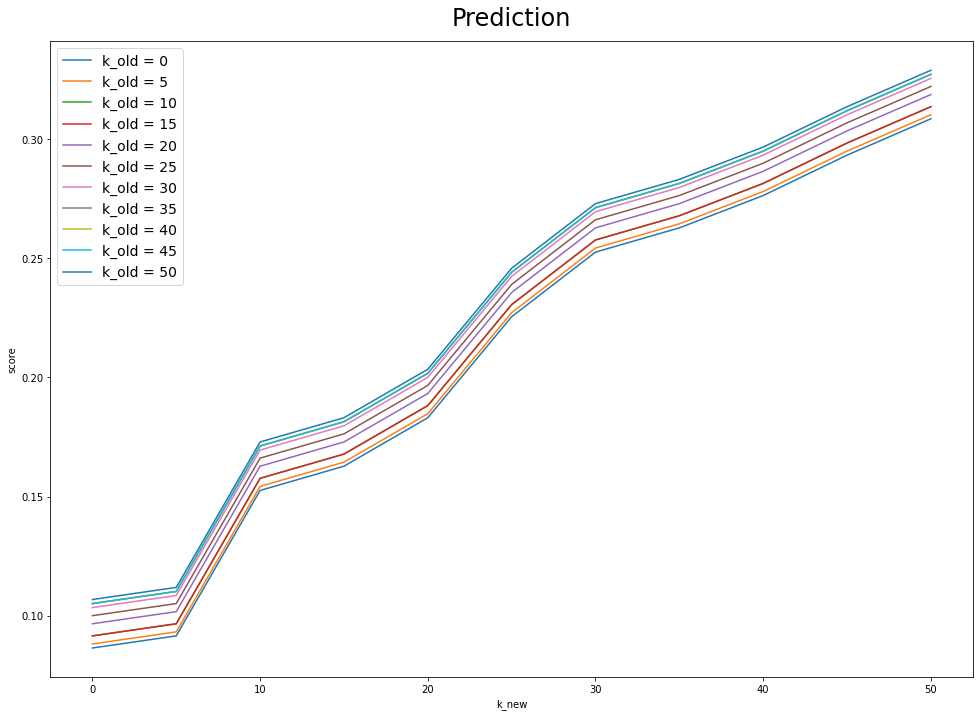

In [65]:
#def graph(predict,start=1,period=10,klim=30):
klim=50
figure, ax = plt.subplots(figsize=(16.53, 11.69))

for k_old in range(0,klim+5,5):
  x=[x for x in range(0,klim+5,5)]
  y=[evaluate(ratings_testings,ratings_testings_by_user, 
            combine(ratings_trainings, users,k=klim,sp_old=k_old,sp_new=k_new)) for k_new in range(0,klim+5,5)]
  ax.plot(x,y,label='k_old = '+str(k_old))

ax.set_xlabel('k_new')
ax.set_ylabel('score')
ax.legend(fontsize=14,title_fontsize=16)
ax.set_title('Prediction',fontsize=24,pad=16)


## Reference

[0 1 1 0 2 1 2 0 0 2 1 0 2 1 1 0 1 1 0 0 1 1 1 0 2 1 0 0 1 2 1 2 1 2 2 0 1
 0 1 2 2 0 1 2 1]
0.9777777777777777


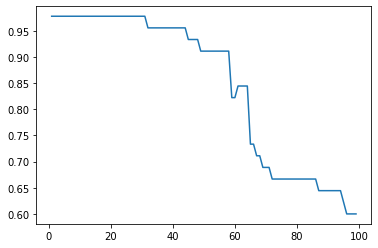

In [39]:
#https://pyecontech.com/2020/05/03/python_knn/
# kmeans

from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics

iris=datasets.load_iris()
X=iris.data
y=iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=1)

clf=KNeighborsClassifier(n_neighbors=3,p=2,weights='distance',algorithm='brute')
clf.fit(X_train,y_train)

print(clf.predict(X_test))
print(clf.score(X_test,y_test))

accuracy = []
for k in range(1, 100):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  accuracy.append(metrics.accuracy_score(y_test, y_pred))

k_range = range(1,100)
plt.plot(k_range, accuracy)
plt.show()
